In [ ]:
import json
import pandas as pd
from pathlib import Path

import json
import pandas as pd
from pathlib import Path

def stream_jsonl_to_parquet(jsonl_path, output_folder, batch_size=10000):
    buffer = []
    batch_num = 0

    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    print(f"Processing {jsonl_path}...")

    with open(jsonl_path, "r") as f:
        for i, line in enumerate(f):
            try:
                obj = json.loads(line)
                if obj.get("label") in [0, 1]:
                    buffer.append(obj)

                if len(buffer) >= batch_size:
                    df = pd.DataFrame(buffer)
                    output_path = output_folder / f"batch_{batch_num}.parquet"
                    df.to_parquet(output_path, index=False, engine="pyarrow", compression='snappy')
                    print(f"  Saved batch {batch_num} with {len(df)} rows to {output_path}")
                    buffer.clear()
                    batch_num += 1

                    break

            except json.JSONDecodeError as e:
                print(f"  Skipping line {i} due to JSON error: {e}")

    # Save any leftover rows
    if buffer:
        df = pd.DataFrame(buffer)
        output_path = output_folder / f"batch_{batch_num}.parquet"
        df.to_parquet(output_path, index=False, engine="pyarrow", compression='snappy')
        print(f"  Saved final batch {batch_num} with {len(df)} rows to {output_path}")

    print(f"Finished processing {jsonl_path}")


# Open and process the JSONL file
input_file = "F://ember//train_features_1.jsonl"
output_dir = "F://ember//parquet_batches"

stream_jsonl_to_parquet(input_file, output_dir)




In [ ]:
#df = pd.read_parquet("F://ember2018//parquet_batches_0//batch_0.parquet")
df = pd.read_parquet("F://ember//parquet_batches//batch_0.parquet")
row = df.iloc[0]

print(df.columns.tolist())
print(row["header"]["optional"].keys())

In [ ]:
import matplotlib.pyplot as plt

df["label"].value_counts().plot(kind="bar", title="Malware vs Benign Distribution")
plt.xticks(ticks=[0, 1], labels=["Benign (0)", "Malware (1)"])
plt.ylabel("Count")
plt.show()

In [ ]:
print(df.columns.tolist())
print(df.iloc[0])

In [4]:
from feature_extractors.pe_feature import PEFeatureExtractor


path = "C://Users//Alisa//Desktop//Unity app//CatKyu!! v3//CatKyu!!.exe"
with open(path, "rb") as f:
    bytez = f.read()
extractor = PEFeatureExtractor()

# Extract the raw feature dict
raw = extractor.raw_features(bytez)

# Turn it into a flat vector (normalized)
vector = extractor.process_raw_features(raw)

print("Feature vector shape:", vector.shape)
print("SHA256 of file:", raw['sha256'])
print("Extracted features: ", raw['imports'])
print("First 10 values of vector:", vector[:100])

Feature vector shape: (2351,)
SHA256 of file: 7bc58a214bb9c0f06a1ee0a7a3a0524f81653caf160b7084861ea6c6c8fd4e21
Extracted features:  {'UnityPlayer.dll': ['UnityMain'], 'KERNEL32.dll': ['HeapAlloc', 'WriteConsoleW', 'QueryPerformanceCounter', 'GetCurrentProcessId', 'GetCurrentThreadId', 'GetSystemTimeAsFileTime', 'InitializeSListHead', 'RtlCaptureContext', 'RtlLookupFunctionEntry', 'RtlVirtualUnwind', 'IsDebuggerPresent', 'UnhandledExceptionFilter', 'SetUnhandledExceptionFilter', 'GetStartupInfoW', 'IsProcessorFeaturePresent', 'GetModuleHandleW', 'CloseHandle', 'RtlUnwindEx', 'GetLastError', 'SetLastError', 'EnterCriticalSection', 'LeaveCriticalSection', 'DeleteCriticalSection', 'InitializeCriticalSectionAndSpinCount', 'TlsAlloc', 'TlsGetValue', 'TlsSetValue', 'TlsFree', 'FreeLibrary', 'GetProcAddress', 'LoadLibraryExW', 'EncodePointer', 'RaiseException', 'RtlPcToFileHeader', 'GetStdHandle', 'WriteFile', 'GetModuleFileNameW', 'GetCurrentProcess', 'ExitProcess', 'TerminateProcess', 'GetMo

In [ ]:
import feature_extractors
data_dir = "F://ember"

feature_extractors.create_vectorized_features(data_dir)
X_train, y_train, X_test, y_test = feature_extractors.read_vectorized_features(data_dir)


Vectorizing training set


100%|██████████| 600000/600000 [13:53<00:00, 719.64it/s] 


Vectorizing testing set


100%|██████████| 200000/200000 [04:32<00:00, 732.99it/s]


In [1]:
import feature_extractors
data_dir = "F://ember"

X_train, y_train, X_test, y_test = feature_extractors.read_vectorized_features(data_dir)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

class DNN(nn.Module):
    def __init__(self, input_dim=2351):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            #nn.Dropout(0.5),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            #nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            #nn.Dropout(0.5),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
import feature_extractors
data_dir = "F://ember"

X, y = feature_extractors.read_vectorized_features(data_dir)
i, j, k = 0, 600000, 800000  

X_train = X[i:j]
y_train = y[i:j]

X_test = X[j:k]
y_test = y[j:k]


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (600000, 2351)
y_train shape: (600000,)
X_test shape: (200000, 2351)
y_test shape: (200000,)


In [9]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X_train[350000:400000], y_train[350000:400000], test_size=0.2, random_state=19, stratify=y_train[350000:400000])

In [9]:
print(X1_train.shape, y1_train.shape)

(40000, 2351) (40000,)


In [10]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Assuming you already have X_train, y_train as numpy arrays, you can create a DataLoader

# Convert your data to PyTorch tensors
X_train_tensor = torch.from_numpy(X1_train).float()  # Assuming X_train is a NumPy array
y_train_tensor = torch.from_numpy(y1_train).float()  # Assuming y_train is a NumPy array

# Create a TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 1024  # Choose an appropriate batch size that doesn't overload your RAM
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [12]:
train_loader = DataLoader(train_ds, batch_size=2048, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=2048)

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [ ]:
model = DNN()
optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = nn.BCELoss()

num_epochs = 2000
loss_values = []
acc_values = []
for epoch in range(num_epochs):
    print(f'Starting Epoch [{epoch+1}/{num_epochs}]')
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    # Iterate through the data in batches
    for xb, yb in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        preds = model(xb)  # Get predictions
        
        loss = criterion(preds, yb.unsqueeze(1))  # Calculate loss (note the unsqueeze to match dims)
        loss.backward()  # Backpropagate the gradients
        optimizer.step()  # Update the model parameters

        running_loss += loss.item()
        
        # Calculate accuracy for the batch
        preds_rounded = (preds > 0.5).float()  # Round predictions to get binary labels
        correct_preds += (preds_rounded == yb.unsqueeze(1)).sum().item()  # Compare with true labels
        total_preds += yb.size(0)  # Count total samples
    
    # Calculate the average loss and accuracy for the epoch
    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_preds / total_preds

    loss_values.append(avg_loss)
    acc_values.append(avg_acc)

    # Print loss and accuracy every 100 epochs (you can adjust as needed)
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Acc: {avg_acc:.4f}')

   

    

Starting Epoch [1/1000]
Starting Epoch [2/1000]
Starting Epoch [3/1000]
Starting Epoch [4/1000]
Starting Epoch [5/1000]
Starting Epoch [6/1000]
Starting Epoch [7/1000]
Starting Epoch [8/1000]
Starting Epoch [9/1000]
Starting Epoch [10/1000]
Starting Epoch [11/1000]
Starting Epoch [12/1000]
Starting Epoch [13/1000]
Starting Epoch [14/1000]
Starting Epoch [15/1000]
Starting Epoch [16/1000]
Starting Epoch [17/1000]
Starting Epoch [18/1000]
Starting Epoch [19/1000]
Starting Epoch [20/1000]
Starting Epoch [21/1000]
Starting Epoch [22/1000]
Starting Epoch [23/1000]
Starting Epoch [24/1000]
Starting Epoch [25/1000]
Starting Epoch [26/1000]
Starting Epoch [27/1000]
Starting Epoch [28/1000]
Starting Epoch [29/1000]
Starting Epoch [30/1000]
Starting Epoch [31/1000]
Starting Epoch [32/1000]
Starting Epoch [33/1000]
Starting Epoch [34/1000]
Starting Epoch [35/1000]
Starting Epoch [36/1000]
Starting Epoch [37/1000]
Starting Epoch [38/1000]
Starting Epoch [39/1000]
Starting Epoch [40/1000]
Starting 

In [12]:
model = DNN()
optimizer = optim.Adam(model.parameters(), lr=0.00001)  # much safer LR (not 0.1!)
criterion = nn.BCELoss()

num_epochs = 2000
loss_values = []
acc_values = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch_idx, (xb, yb) in enumerate(train_loader):
        optimizer.zero_grad()
        preds = model(xb)
        
        loss = criterion(preds, yb.unsqueeze(1))  # important: use raw preds for loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds_rounded = preds.round()
        correct_preds += (preds_rounded == yb.unsqueeze(1)).sum().item()
        total_preds += yb.size(0)

        # compute batch accuracy
        batch_acc = (preds_rounded == yb.unsqueeze(1)).float().mean().item()

        # Print per batch
        #print(f"Batch {batch_idx+1}/{len(train_loader)} — Loss: {loss.item():.4f}, Batch Acc: {batch_acc:.4f}")

    # Epoch summary
    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_preds / total_preds

    # Save loss and accuracy
    if (epoch + 1) % 10 == 0:
        loss_values.append(avg_loss)
        acc_values.append(avg_acc)

    # Print every 100 epochs
    if (epoch + 1) % 10 == 0:
        print(f"[Epoch {epoch+1}] Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")


[Epoch 10] Avg Loss: 0.5684, Avg Acc: 0.7123
[Epoch 20] Avg Loss: 0.5442, Avg Acc: 0.7300
[Epoch 30] Avg Loss: 0.5187, Avg Acc: 0.7498
[Epoch 40] Avg Loss: 0.4995, Avg Acc: 0.7567
[Epoch 50] Avg Loss: 0.4895, Avg Acc: 0.7623
[Epoch 60] Avg Loss: 0.4879, Avg Acc: 0.7676
[Epoch 70] Avg Loss: 0.4786, Avg Acc: 0.7700
[Epoch 80] Avg Loss: 0.4670, Avg Acc: 0.7772
[Epoch 90] Avg Loss: 0.4659, Avg Acc: 0.7788
[Epoch 100] Avg Loss: 0.4540, Avg Acc: 0.7859
[Epoch 110] Avg Loss: 0.4487, Avg Acc: 0.7871
[Epoch 120] Avg Loss: 0.4387, Avg Acc: 0.7956
[Epoch 130] Avg Loss: 0.4450, Avg Acc: 0.7901
[Epoch 140] Avg Loss: 0.4397, Avg Acc: 0.7980
[Epoch 150] Avg Loss: 0.4367, Avg Acc: 0.7970
[Epoch 160] Avg Loss: 0.4320, Avg Acc: 0.7985
[Epoch 170] Avg Loss: 0.4428, Avg Acc: 0.7942
[Epoch 180] Avg Loss: 0.4266, Avg Acc: 0.8040
[Epoch 190] Avg Loss: 0.4350, Avg Acc: 0.7971
[Epoch 200] Avg Loss: 0.4195, Avg Acc: 0.8069
[Epoch 210] Avg Loss: 0.4229, Avg Acc: 0.8066
[Epoch 220] Avg Loss: 0.4064, Avg Acc: 0.81

KeyboardInterrupt: 

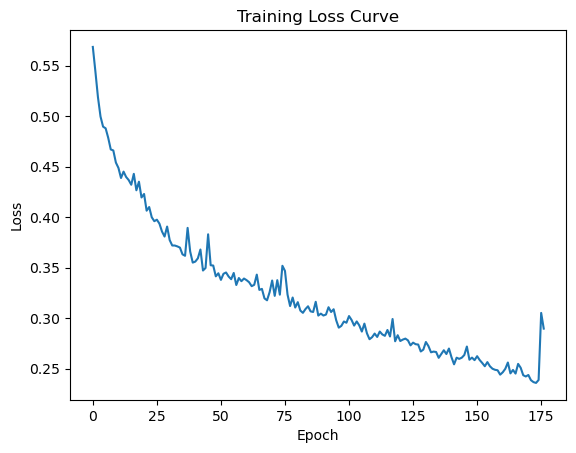

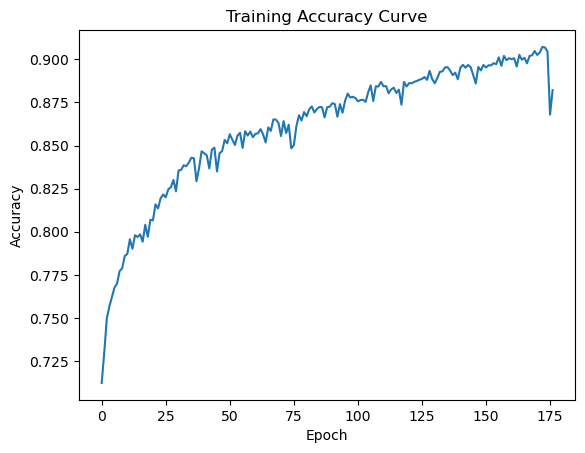

In [13]:
from typing import List
import matplotlib.pyplot as plt
def plot_loss(loss_values: List[float]):
    plt.plot(loss_values)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()
    
def plot_acc(acc_values: List[float]):
    plt.plot(acc_values)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Curve')
    plt.show()

plot_loss(loss_values)
plot_acc(acc_values)